In [ ]:
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

arr = np.load("logits_class_raw")

arr = arr.reshape(-1, 1024)

arr = torch.from_numpy(arr)

arr = F.sigmoid(arr).round().float()

ans = np.zeros(shape=(arr.shape[0],))

for i, sample in enumerate(arr):
    idx = sample.nonzero()[0]
    ans[i] = idx
# np.save("logits_class.npy", ans)

torch.Size([4998, 1024])


(4998,)


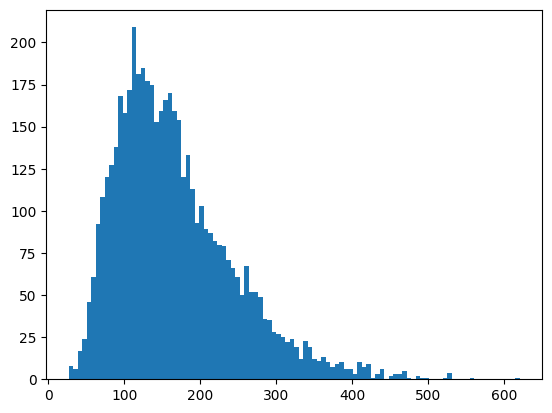

In [36]:
import matplotlib.pyplot as plt
arr = np.load("logits_regr_old.npy")
print(arr.shape)
plt.hist(arr, bins = 100)
plt.show()

In [1]:
# Only for the logits classifier. Plot the performance as a function of the threshold.
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# dir1/dir2/this_file.py
# I want to get
# dir1/data/test.csv
path_to_test = os.path.join(
    "..",
    "data",
    "test.csv"
)

# Read in the prompts
df = pd.read_csv(path_to_test)

# Init the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "GSAI-ML/LLaDA-8B-Instruct"
)

# Get GT lengths
gt = [
    len(tokenizer(response)["input_ids"])
    for response in df.model_response.dropna()
]
n_test_samples = len(gt)
print(f"Evaluating {n_test_samples} test instances...")

# Load logits
logits = np.load("logits_class_raw")
logits = logits.reshape(-1, 1024)
logits = torch.from_numpy(logits)
probs = F.sigmoid(logits)

# Get prediction per threshold
thresh = np.arange(0, 1, 0.1)
preds = {
    thr:np.zeros(shape=(len(gt),))
    for thr in thresh
}
for thr in thresh:
    # Preds for this thresh
    tmp = torch.greater_equal(probs, thr).float()

    for i, sample in enumerate(tmp):   
        idx = sample.nonzero()[0]
        preds[thr][i] = idx

# Store results
ans = {
    thr:{
        "above":[],
        "below":[],
        "exact":[]
    } for thr in thresh
}

for i in tqdm(range(len(gt))):
    
    # Get true
    true = gt[i]

    # Evaluate each pred
    for thr in thresh:
        
        # Pred for this model
        pred = preds[thr][i]
        
        # Model predict exact length
        if pred == true:
            # print(f"Wow! {model} predicted the exact length ({pred}) of the {i}-th test instance!")
            k = "exact"
        # Model predicted more than true length (good)
        elif pred > true:
            k = "above"
        # Model predicted less than true length (bad)
        elif pred < true:
            k = "below"

        # Store the tuple in the correct place
        ans[thr][k].append(
                (pred-true).item()
            )

# Get aggregate metrics
ans_df = pd.DataFrame(
    columns=[
        "Model",
        "Below",
        "Above",
        "Exact",
        "Below_avg",
        "Above_avg"
    ]
)

for i, model in enumerate(preds.keys()):
    
    # The model name
    ans_df.loc[i, "Model"] = model
    
    # How many above, below, exact predicted (with avg)
    for k in ["above", "below", "exact"]:
        ans_df.loc[i, k.capitalize()] = len(ans[model][k]) / n_test_samples * 100
        if k != "exact":
            ans_df.loc[i, f"{k.capitalize()}_avg"] = np.mean(ans[model][k]).item()

    # Compute mse
    ans_df.loc[i, "MSE"] = np.mean(
        np.power(
            ans[model]["above"] + ans[model]["below"] + ans[model]["exact"],
            2
        )
    ).item()

# ans_df = ans_df.set_index("Model")
ans_df['Model'] = ans_df['Model'].apply(lambda x: f"{x:.1f}")
ans_df.Below_avg = - ans_df.Below_avg
ans_df = ans_df.rename(columns={"Below_avg":"Below (avg.)","Above_avg":"Above (avg.)"})
# Print the result
# print(ans_df.to_string())


/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating 4998 test instances...


100%|██████████| 4998/4998 [00:00<00:00, 93813.24it/s]
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


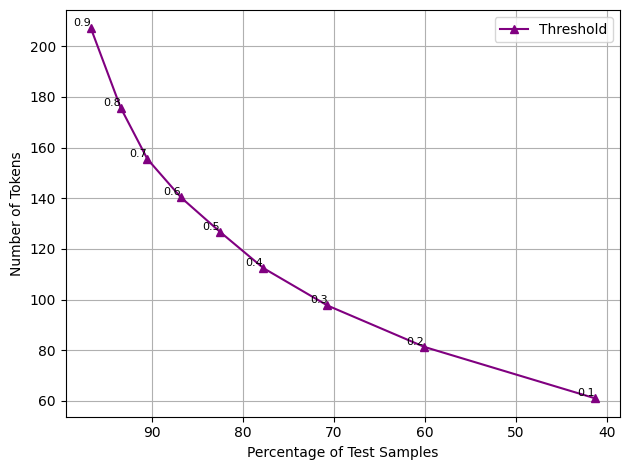

In [36]:
import matplotlib.pyplot as plt

plt.figure()

# Plot Above curve
plt.plot(
    ans_df["Above"],
    ans_df["Above (avg.)"],
    marker="^",
    color="purple",
    linestyle="-",
    label="Threshold"
)

# Annotate Above points with threshold (Model)
for x, y, label in zip(ans_df["Above"], ans_df["Above (avg.)"], ans_df["Model"]):
    plt.text(x, y, str(label), fontsize=8, ha='right', va='bottom')

# Plot Below curve
# plt.plot(
#     ans_df["Below"],
#     ans_df["Below (avg.)"],
#     marker="v",
#     color="green",
#     linestyle="-",
#     label="Below"
# )

# # Annotate Below points with threshold (Model)
# for x, y, label in zip(ans_df["Below"], ans_df["Below (avg.)"], ans_df["Model"]):
#     plt.text(x, y, str(label), fontsize=8, ha='left', va='top')

plt.xlabel("Percentage of Test Samples")
plt.ylabel("Number of Tokens")
# plt.title("Pareto Curves: Above/Below vs Above/Below (avg.)")
plt.gca().invert_xaxis()  # Reverse x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("pareto.png")
plt.show()


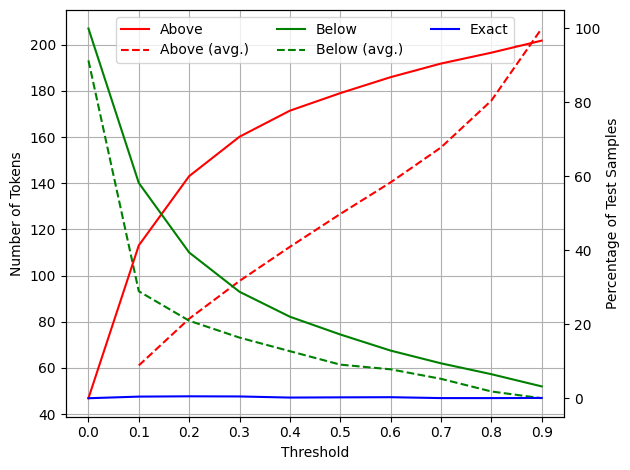

In [37]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First y-axis (left): Number of Tokens
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number of Tokens", color="black")
ax1.plot(ans_df["Model"], ans_df["Above (avg.)"], linestyle="--", color="red", label="Above (avg.)")
ax1.plot(ans_df["Model"], ans_df["Below (avg.)"], linestyle="--", color="green", label="Below (avg.)")
ax1.tick_params(axis='y', labelcolor="black")
ax1.grid(True)
# Second y-axis (right): Percentage of Test Samples
ax2 = ax1.twinx()
ax2.set_ylabel("Percentage of Test Samples", color="black")
ax2.plot(ans_df["Model"], ans_df["Above"], color="red", label="Above")
ax2.plot(ans_df["Model"], ans_df["Exact"], color="blue", label="Exact")
ax2.plot(ans_df["Model"], ans_df["Below"], color="green", label="Below")
ax2.tick_params(axis='y', labelcolor="black")

# Optional: Combine legends
# Combine and sort legend entries alphabetically by label
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
combined = lines1 + lines2
labels = labels1 + labels2
sorted_pairs = sorted(zip(labels, combined), key=lambda x: x[0])
sorted_labels, sorted_lines = zip(*sorted_pairs)
ax1.legend(sorted_lines, sorted_labels, loc="upper center", ncol=3)
# plt.title("Threshold Analysis")
plt.tight_layout()

plt.savefig("thr_analysis.png")
plt.show()
plt.close()


In [40]:
import re

def transform_latex_table(latex_code):
    # Extract the table content (everything between \begin{tabular} and \end{tabular})
    table_pattern = r'\\begin{tabularx}.*?}(.*?)\\end{tabularx}'
    table_match = re.search(table_pattern, latex_code, re.DOTALL)
    
    if not table_match:
        return "No valid LaTeX table found"
    
    table_content = table_match.group(1)
    
    # Extract rows (split by \\)
    rows = table_content.strip().split('\\\\')
    rows = [row.strip() for row in rows if row.strip()]
    
    # Process the header
    header_row = rows[0]
    header_cells = [cell.strip() for cell in header_row.split('&')]
    
    # Find the indices of the columns to combine
    below_idx = next((i for i, header in enumerate(header_cells) if '\\% below' in header), None)
    above_idx = next((i for i, header in enumerate(header_cells) if '\\% above' in header), None)
    exact_idx = next((i for i, header in enumerate(header_cells) if '\\% exact' in header), None)
    
    below_avg_idx = next((i for i, header in enumerate(header_cells) if 'Below (avg.)' in header), None)
    above_avg_idx = next((i for i, header in enumerate(header_cells) if 'Above (avg.)' in header), None)
    
    # Create new headers
    new_headers = []
    combined_pct_added = False
    combined_avg_added = False
    
    for i, header in enumerate(header_cells):
        if i in [below_idx, above_idx, exact_idx]:
            if not combined_pct_added:
                new_headers.append("Percentages (\\% below, \\% above, \\% exact)")
                combined_pct_added = True
        elif i in [below_avg_idx, above_avg_idx]:
            if not combined_avg_added:
                new_headers.append("Averages (above avg., below avg.)")
                combined_avg_added = True
        else:
            new_headers.append(header)
    
    # Process data rows
    new_rows = []
    for i in range(1, len(rows)):
        row = rows[i]
        cells = [cell.strip() for cell in row.split('&')]
        
        new_cells = []
        pct_values = []
        avg_values = []
        
        for j, cell in enumerate(cells):
            if j in [below_idx, above_idx, exact_idx]:
                pct_values.append(cell)
            elif j in [below_avg_idx, above_avg_idx]:
                avg_values.append(cell)
            else:
                new_cells.append(cell)
        
        # Add combined cells
        if pct_values:
            combined_pct = f"({pct_values[0]}, {pct_values[1]}, {pct_values[2]})"
            new_cells.insert(below_idx, combined_pct)
        
        if avg_values:
            combined_avg = f"({avg_values[1]}, {avg_values[0]})"  # above_avg, below_avg
            new_cells.insert(min(below_avg_idx, above_avg_idx), combined_avg)
        
        new_rows.append(new_cells)
    
    # Rebuild the table
    new_table_content = ' & '.join(new_headers) + ' \\\\'
    for row in new_rows:
        new_table_content += '\n' + ' & '.join(row) + ' \\\\'
    
    # Replace the original table content with the new one
    new_latex_code = re.sub(
        table_pattern,
        lambda m: m.group(0).replace(table_match.group(1), new_table_content),
        latex_code,
        flags=re.DOTALL
    )
    
    return new_latex_code

# Example usage:
latex_table = r'''
\begin{table*}[htbp]
\centering
\caption{\textbf{Length Prediction Approaches.} Comparison of different prediction mechanisms used for length estimation and sequence termination. \textcolor{red}{simplify table (below, exact, above) as a single column of tuples, tokens below, above as a single column of tuples}}
\label{tab:model_performance}
\begin{tabularx}{\linewidth}{lYYYYYYYY}
\toprule
\textbf{Method} & \textbf{Variant} &\textbf{\% Below} & \textbf{\% Above} & \textbf{\% Exact} & \textbf{\# Tokens Below} & \textbf{\# Tokens Above} & \textbf{RMSE} \\ \midrule
\multirow{2}{*}{DistilBERT} & Classifier& 18.03 & 81.75 & 0.22 & 69.55 & 158.49 & 183.83 \\
\cmidrule{2-8}
& Regressor &42.10 & 57.46 & 0.44 & 72.78 & 71.16 & 91.68 \\
\midrule
\multirow{5}{*}{LlaDa} & Q25 & 40.66 & 59.06 & 0.28 & 115.65 & 117.33 & 141.42 \\
\cmidrule{2-8}
& Q50 &2.64 & 97.36 & 0.00 & 104.63 & 292.82 & 310.55 \\
\cmidrule{2-8}
& Q75 &0.12 & 99.88 & 0.00 & 173.67 & 510.05 & 520.31 \\
\cmidrule{2-8}
& Classifier&17.25 & 82.51 & 0.24 & 61.45 & 126.69 & 137.33  \\
\cmidrule{2-8}
& Regressor&53.62 & 46.38 & 0.00 & 98.72 & 63.97 & 106.24  \\
\midrule
\textit{Random}& &28.23 & 71.57 & 0.20 & -133.00 & 269.72 & 281.84  \\
\cmidrule{2-8}
\textit{Mean}& &48.28 & 51.46 & 0.26 & 99.69 & 93.10 & 114.97 \\
\cmidrule{2-8}
\textit{Max}& &0.00 & 99.98 & 0.02 & - & 505.88 & 518.69   \\
\cmidrule{2-8}
\textit{Min}& & 99.64 & 0.00 & 0.36 & 191.91 & - & 223.12 \\
\bottomrule
\end{tabularx}
\end{table*}
'''

transformed_table = transform_latex_table(latex_table)
print(transformed_table)


\begin{table*}[htbp]
\centering
\caption{\textbf{Length Prediction Approaches.} Comparison of different prediction mechanisms used for length estimation and sequence termination. \textcolor{red}{simplify table (below, exact, above) as a single column of tuples, tokens below, above as a single column of tuples}}
\label{tab:model_performance}
\begin{tabularx}{\linewidth}{lYYYYYYYY}
\toprule
\textbf{Method} & \textbf{Variant} & \textbf{\% Below} & \textbf{\% Above} & \textbf{\% Exact} & \textbf{\# Tokens Below} & \textbf{\# Tokens Above} & \textbf{RMSE} \\
\midrule
\multirow{2}{*}{DistilBERT} & Classifier & 18.03 & 81.75 & 0.22 & 69.55 & 158.49 & 183.83 \\
\cmidrule{2-8} & Regressor & 42.10 & 57.46 & 0.44 & 72.78 & 71.16 & 91.68 \\
\midrule
\multirow{5}{*}{LlaDa} & Q25 & 40.66 & 59.06 & 0.28 & 115.65 & 117.33 & 141.42 \\
\cmidrule{2-8} & Q50 & 2.64 & 97.36 & 0.00 & 104.63 & 292.82 & 310.55 \\
\cmidrule{2-8} & Q75 & 0.12 & 99.88 & 0.00 & 173.67 & 510.05 & 520.31 \\
\cmidrule{2-8} & Classi